# Cats Versus Dogs Classifier

Dog and cat image classifier with deep learning. We are implementing Convolution Neural Network(CNN) Classifier for Classifying dog and cat images.

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import os

Downloading the cats and dogs dataset

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

 Proper file path for the training and validation data are set.

In [4]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [5]:
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Image data generators are used for Image Augmentation

In [6]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale=1./255,
  rotation_range=20,
  width_shift_range=.1,
  height_shift_range=.1,
  horizontal_flip=True
)
validation_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [7]:
train_data_gen = train_image_generator.flow_from_directory(
  batch_size=128,
  directory=train_dir,
  shuffle=True,
  target_size=(150, 150),
  class_mode='binary')

Found 2000 images belonging to 2 classes.


In [8]:
val_data_gen = validation_image_generator.flow_from_directory(
  batch_size=128,
  directory=validation_dir,
  target_size=(150, 150),
  class_mode='binary')

Found 1000 images belonging to 2 classes.


Using the Inception v3 model for transfer learning.

In [9]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-07-22 07:02:55--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   121MB/s    in 0.7s    

2020-07-22 07:02:56 (121 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [10]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [11]:
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3),
    include_top=False,
    weights=None
)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [12]:
last_layer = pre_trained_model.get_layer('mixed8')
print('last layer output shape: ', last_layer.output_shape)

last layer output shape:  (None, 3, 3, 1280)


In [13]:
flatten = tf.keras.layers.Flatten()(last_layer.output)

dense_layer = tf.keras.layers.Dense(640, activation='relu')(flatten)
dropout_layer = tf.keras.layers.Dropout(0.32)(dense_layer)

x = tf.keras.layers.Dense(64, activation='relu')(dropout_layer)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

In [14]:
model = tf.keras.models.Model(pre_trained_model.input, output_layer)

In [15]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [17]:
epochs = 32

In [18]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=2000//128,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=1000//128
)

Epoch 1/32
15/15 [==============================] - 16s 1s/step - loss: 0.4704 - accuracy: 0.7975 - val_loss: 0.1903 - val_accuracy: 0.9230
Epoch 2/32
15/15 [==============================] - 15s 1s/step - loss: 0.1949 - accuracy: 0.9199 - val_loss: 0.1175 - val_accuracy: 0.9520
Epoch 3/32
15/15 [==============================] - 15s 1s/step - loss: 0.1630 - accuracy: 0.9327 - val_loss: 0.1237 - val_accuracy: 0.9442
Epoch 4/32
15/15 [==============================] - 15s 1s/step - loss: 0.1423 - accuracy: 0.9412 - val_loss: 0.0884 - val_accuracy: 0.9676
Epoch 5/32
15/15 [==============================] - 15s 1s/step - loss: 0.1113 - accuracy: 0.9487 - val_loss: 0.0811 - val_accuracy: 0.9688
Epoch 6/32
15/15 [==============================] - 15s 1s/step - loss: 0.1234 - accuracy: 0.9503 - val_loss: 0.1035 - val_accuracy: 0.9598
Epoch 7/32
15/15 [==============================] - 15s 997ms/step - loss: 0.1037 - accuracy: 0.9610 - val_loss: 0.0750 - val_accuracy: 0.9721
Epoch 8/32
15/15 

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

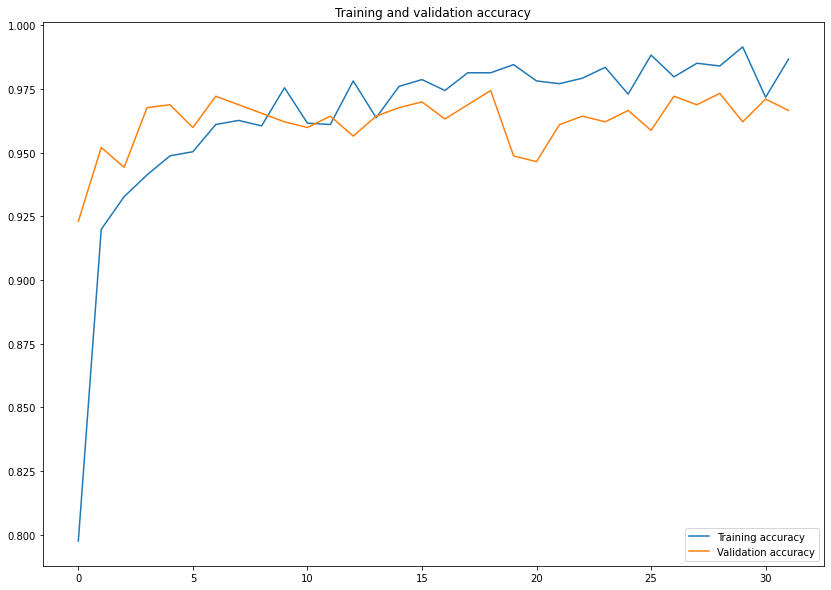

In [20]:
plt.figure(figsize=(14, 10))
plt.plot(range(epochs), acc, label='Training accuracy')
plt.plot(range(epochs), val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

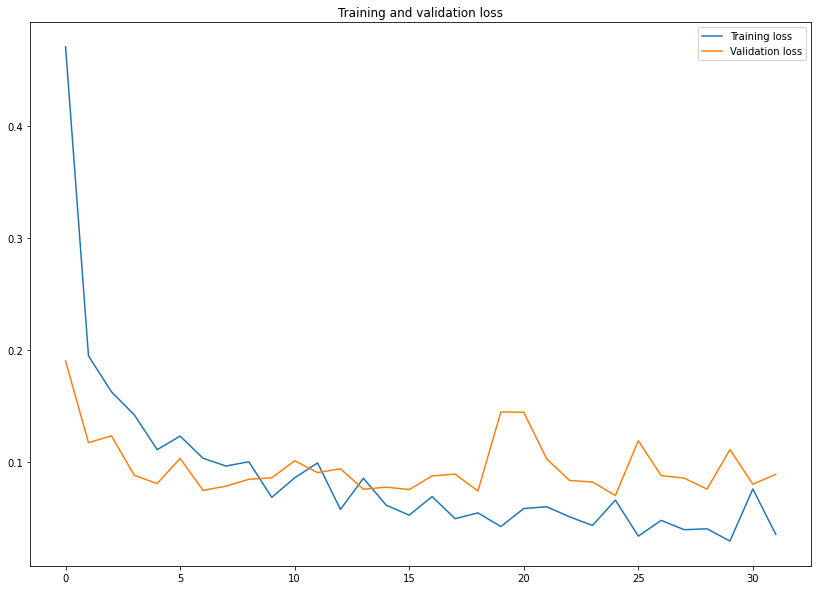

In [21]:
plt.figure(figsize=(14, 10))
plt.plot(range(epochs), loss, label='Training loss')
plt.plot(range(epochs), val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='upper right')
plt.show()